# Gradslam test


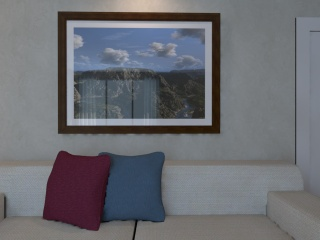
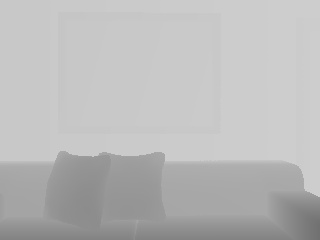
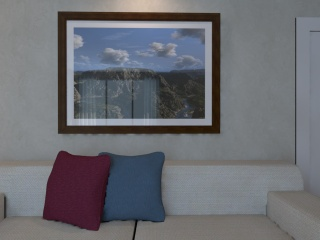
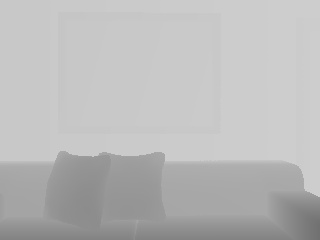
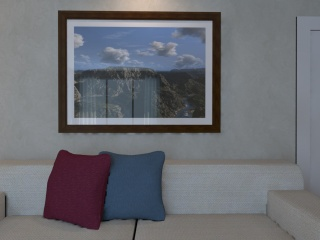
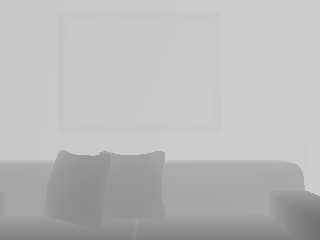
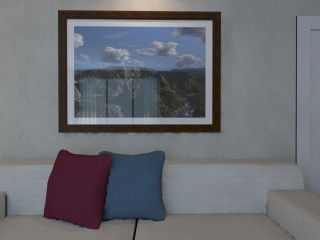
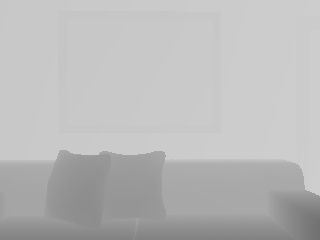
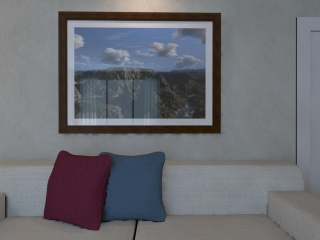
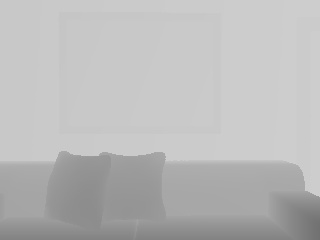
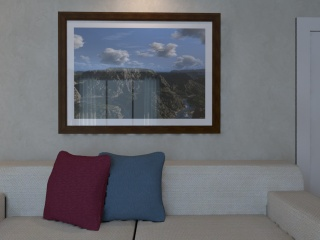
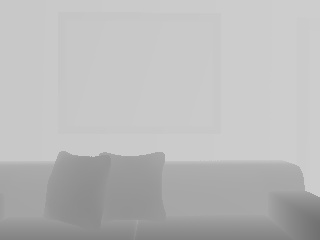
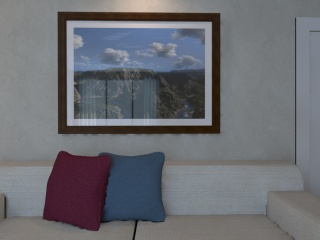
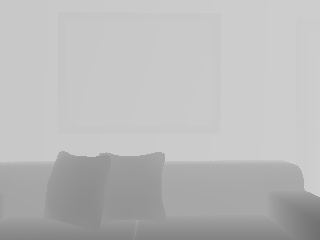
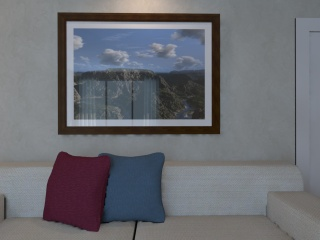
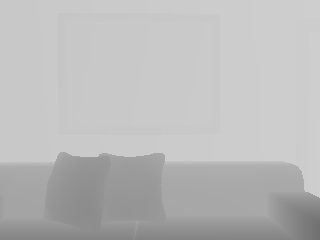
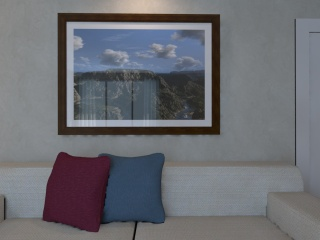
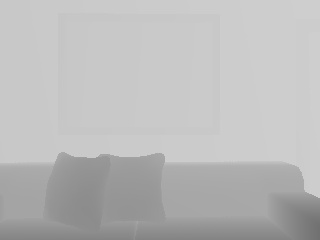

In [23]:
# import necessary packages
import gradslam as gs
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from gradslam import Pointclouds, RGBDImages
from gradslam.datasets import ICL
from gradslam.slam import PointFusion
from torch.utils.data import DataLoader

# download 'lr kt1' of ICL dataset
if not os.path.isdir('ICL'):
    os.mkdir('ICL')
if not os.path.isdir('ICL/living_room_traj1_frei_png'):
    print('Downloading ICL/living_room_traj1_frei_png dataset...')
    os.mkdir('ICL/living_room_traj1_frei_png')
    !wsl wget http://www.doc.ic.ac.uk/~ahanda/living_room_traj1_frei_png.tar.gz -P ICL/living_room_traj1_frei_png/ -q
    !wsl tar -xzf ICL/living_room_traj1_frei_png/living_room_traj1_frei_png.tar.gz -C ICL/living_room_traj1_frei_png/
    !wsl rm ICL/living_room_traj1_frei_png/living_room_traj1_frei_png.tar.gz
    !wsl wget https://www.doc.ic.ac.uk/~ahanda/VaFRIC/livingRoom1n.gt.sim -P ICL/living_room_traj1_frei_png/ -q
    print('Downloaded.')
icl_path = 'ICL/'

# load dataset
dataset = ICL(icl_path, seqlen=8, height=240, width=320)
loader = DataLoader(dataset=dataset, batch_size=2)
colors, depths, intrinsics, poses, *_ = next(iter(loader))

# create rgbdimages object
rgbdimages = RGBDImages(colors, depths, intrinsics, poses)
rgbdimages.plotly(0).update_layout(autosize=False, height=600, width=400).show()

2.052999973297119


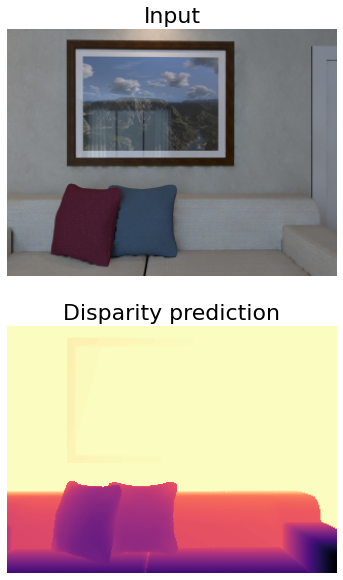

In [53]:
frame = 0
color = colors[0,frame]
depth = depths[0,frame]

color_img = color.cpu().numpy().astype(np.uint)
depth_img = depth.cpu().numpy()
vmax = np.percentile(depth_img, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(color_img)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(depth_img, cmap='magma', vmax=2)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

print(vmax)

In [43]:
color.numpy().shape

(240, 320, 3)

In [30]:
intrinsics.shape

torch.Size([2, 1, 4, 4])

In [24]:
depths.shape

torch.Size([2, 8, 240, 320, 1])

# RGBD images tutorial

In [25]:
print(f"colors shape: {colors.shape}")  # torch.Size([2, 8, 240, 320, 3])
print(f"depths shape: {depths.shape}")  # torch.Size([2, 8, 240, 320, 1])
print(f"intrinsics shape: {intrinsics.shape}")  # torch.Size([2, 1, 4, 4])
print(f"poses shape: {poses.shape}")  # torch.Size([2, 8, 4, 4])
print('---')

# instantiation without poses
rgbdimages = RGBDImages(colors, depths, intrinsics)
print(rgbdimages.shape)  # (2, 8, 240, 320)
print(rgbdimages.poses)  # None
print('---')

# instantiation with poses
rgbdimages = RGBDImages(colors, depths, intrinsics, poses)
print(rgbdimages.shape)  # (2, 8, 240, 320)

colors shape: torch.Size([2, 8, 240, 320, 3])
depths shape: torch.Size([2, 8, 240, 320, 1])
intrinsics shape: torch.Size([2, 1, 4, 4])
poses shape: torch.Size([2, 8, 4, 4])
---
(2, 8, 240, 320)
None
---
(2, 8, 240, 320)


In [26]:
# initalize RGBDImages
rgbdimages = RGBDImages(colors, depths, intrinsics, poses)

# indexing
rgbdimages0 = rgbdimages[0, 0]
print(rgbdimages0.shape)  # (1, 1, 240, 320)
print('---')

# slicing
rgbdimages1 = rgbdimages[:2, :5]
print(rgbdimages1.shape)  # (2, 5, 240, 320)
print('---')

(1, 1, 240, 320)
---
(2, 5, 240, 320)
---


# POINT CLOUD TUTORIAL

In [54]:
from gradslam.structures.utils import pointclouds_from_rgbdimages

# instantiate empty Pointclouds object
pointclouds = Pointclouds()
print(pointclouds.has_points)  # False
print('---')

# instantiation from list of tensors of points
pointclouds = Pointclouds(points=[torch.rand(4, 3), torch.rand(2, 3), torch.rand(1, 3)],
                          normals=[torch.rand(4, 3), torch.rand(2, 3), torch.rand(1, 3)],
                          colors=[torch.rand(4, 3), torch.rand(2, 3), torch.rand(1, 3)])
print(pointclouds.num_points_per_pointcloud)  # tensor([4, 2, 1])
print('---')

# instantiation from tensor
pointclouds = Pointclouds(points=torch.rand(3, 4, 3),
                          normals=torch.rand(3, 4, 3),
                          colors=torch.rand(3, 4, 3))
print(pointclouds.num_points_per_pointcloud)  # tensor([4, 4, 4])
print('---')

# instantiate with features
# features can have any number of dimensions
pointclouds = Pointclouds(points=torch.rand(3, 4, 3),
                          normals=torch.rand(3, 4, 3),
                          colors=torch.rand(3, 4, 3),
                          features=torch.rand(3, 4, 10))
print(pointclouds.has_features)  # True
print('---')

# instantiate from RGBDImages with sequence length of 1
rgbdimages1 = rgbdimages[:, 0]
pointclouds = pointclouds_from_rgbdimages(rgbdimages1, filter_missing_depths=False)
print(rgbdimages1.shape)  # (2, 1, 240, 320)
print(pointclouds.num_points_per_pointcloud)  # tensor([76800, 76800])

False
---
tensor([4, 2, 1])
---
tensor([4, 4, 4])
---
True
---
(2, 1, 240, 320)
tensor([76800, 76800])
